In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForQuestionAnswering
from transformers import pipeline
from transformers import BitsAndBytesConfig
from sentence_transformers import SentenceTransformer, util
from torch.nn.functional import cosine_similarity

from langchain.agents import load_tools
from langchain.agents import initialize_agent
from langchain.llms import HuggingFacePipeline

from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sb

import pandas as pd
import numpy as np
from tqdm import tqdm
import time
import re
import accelerate

2024-09-22 23:04:58.501906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 23:04:58.501955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 23:04:58.502967: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 23:04:58.509924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 23:04:59.498249: W tensorflow/compiler/tf2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### Dataset Preparation

In [3]:
def load_dataset(n_samples=None):
    splits = {'test': 'college_mathematics/test-00000-of-00001.parquet', 'validation': 'college_mathematics/validation-00000-of-00001.parquet', 'dev': 'abstract_algebra/dev-00000-of-00001.parquet'}
    dataset = pd.read_parquet("hf://datasets/cais/mmlu/" + splits["test"])
    dataset.drop(columns='subject', inplace=True)
    dataset.dropna(inplace=True)
    dataset.reset_index(drop=True, inplace=True)
    dataset = dataset[:n_samples]
    dataset['answer'] = dataset['answer'] + 1
    return dataset

In [4]:
dataset = load_dataset(100)
dataset

,question,choices,answer
0,Let k be the number of real solutions of the e...,"[k = 0 and n = 1, k = 1 and n = 0, k = n = 1, ...",2
1,"Up to isomorphism, how many additive abelian g...","[0, 1, 2, 3]",4
2,Suppose P is the set of polynomials with coeff...,"[n = 1 and r = 6, n = 1 and r = 7, n = 2 and r...",4
3,The shortest distance from the curve xy = 8 to...,"[4, 8, 16, 2sqrt(2)]",1
4,"There are 25 suitcases, 5 of which are damaged...","[2/69, 1/30, 2/23, 12/125]",3
...,...,...,...
95,"If U and V are 3-dimensional subspaces of R^5,...","[0, 1, 0 or 1, 1, 2, or 3]",4
96,Let S be the subset of R^2 consisting of all p...,"[closed, open, connected, totally disconnected]",3
97,Which of the following circles has the greates...,"[x^2 + y^2 = 1, x^2 + y^2 = 2, x^2 + y^2 = 9, ...",3
98,X is a finite set with the following property:...,"[24, 25, 28, 35]",4


In [5]:
answers = dataset['answer'].to_numpy()
answers

array([2, 4, 4, 1, 3, 4, 3, 3, 3, 1, 4, 2, 1, 2, 4, 4, 2, 3, 4, 1, 4, 4,
       2, 1, 2, 4, 4, 1, 1, 2, 3, 2, 2, 3, 4, 4, 1, 1, 1, 3, 2, 4, 4, 1,
       4, 1, 2, 2, 3, 4, 1, 2, 3, 3, 1, 4, 2, 4, 3, 1, 2, 1, 1, 4, 2, 4,
       3, 4, 1, 1, 4, 4, 4, 4, 3, 4, 4, 3, 2, 2, 3, 2, 2, 3, 3, 2, 1, 3,
       3, 3, 2, 3, 3, 2, 4, 4, 3, 3, 4, 1])

#### LLM Preparation

In [3]:
llama_model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
phi_model_id = 'microsoft/Phi-3.5-mini-instruct'
gemma_model_id = 'google/gemma-2b-it'

In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type='nf4',  # Can be 'nf4' or 'fp4'
    bnb_4bit_compute_dtype=torch.bfloat16  # Adjust compute type if needed
)

In [5]:
def init_llm(model_id, quantization_config=None):
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map='cuda',
    quantization_config=quantization_config,
    )
    return model, tokenizer

In [6]:
def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    total_size_bytes = total_params * 2
    total_size_gb = total_size_bytes / (1024 ** 3)
    return f"Model size = {total_size_gb:.2f} GB"

#### Prepare Prompt Types

In [9]:
prompt_types = ["zero_shot", "chain_of_thought", "react"]
llm_types = ["llama", "phi", "gemma"]

model_sizes = {llm: 0 for llm in llm_types}
model_times = {llm: {p: 0 for p in prompt_types} for llm in llm_types}
model_accuracies = {llm: {p: 0 for p in prompt_types} for llm in llm_types}

In [10]:
def extract_option(responses, pattern=r'Answer:\sOption\s(\d+)'):
    answers = []
    for response in responses:
        match = re.search(pattern, response)
        if match:
            ans = match.group(1)
            answers.append(ans)
        else:
            answers.append('0')
    return np.array(answers, dtype=int)

In [15]:
def generate_response(prompt, model, tokenizer, max_tokens=40):
    messages = [
        {"role": "system", "content": "You are a mathematical multiple-choice question-answering chatbot! Choose the correct option for the given question and output in the format 'Answer: Option x'."},
        {"role": "user", "content": prompt},
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    start_time = time.time()

    outputs = model.generate(
        input_ids,
        max_new_tokens=max_tokens,
        eos_token_id=terminators,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )

    end_time = time.time()
    inference_time = end_time - start_time

    response = outputs[0][input_ids.shape[-1]:]
    del input_ids
    torch.cuda.empty_cache()
    return tokenizer.decode(response, skip_special_tokens=True), inference_time

In [70]:
def generate_response_gemma(prompt, model, tokenizer, max_tokens=40):
    messages = [
        {"role": "user", "content": prompt},
    ]

    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(model.device)

    terminators = [
        tokenizer.eos_token_id,
        tokenizer.convert_tokens_to_ids("<|eot_id|>")
    ]

    start_time = time.time()

    outputs = model.generate(
        input_ids,
        max_new_tokens=max_tokens,
        eos_token_id=terminators,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True,
        temperature=0.6,
        top_p=0.9,
    )

    end_time = time.time()
    inference_time = end_time - start_time

    response = outputs[0][input_ids.shape[-1]:]
    del input_ids
    torch.cuda.empty_cache()
    return tokenizer.decode(response, skip_special_tokens=True), inference_time

In [ ]:
class ReactAgent:
    def __init__(self, model, tokenizer, system_prompt='', reason_prompt="", action_prompt="", verbose=False):
        self.system_prompt = system_prompt
        self.reason_prompt = reason_prompt
        self.action_prompt = action_prompt
        self.model = model
        self.tokenizer = tokenizer
        self.end_pattern = r'Option\s(\d+)'
        self.max_steps = 10
        self.verbose = verbose

    def __call__(self, prompt, max_tokens=1000):
        self.inference_time = 0
        self.history = {'Reasoning': [], 'Action': []}

        for step in range(self.max_steps):
            reason, r_time = self.reasoning(prompt, max_tokens)
            if self.verbose:
                print(f'\n\nReasoning Performed:\n{reason}')
            self.history['Reasoning'].append(reason)

            action, a_time = self.action(prompt, max_tokens)
            if self.verbose:
                print(f'\n\nAction Taken:\n{action}')
            self.history['Action'].append(action)

            self.inference_time += r_time + a_time

            match = re.search(self.end_pattern, action)
            if match:
                break
        return action, self.inference_time

    def reasoning(self, prompt, max_tokens=1000):
        self.messages = []
        history_prompt = ''

        if len(self.history['Action']):
            # history_prompt = '\n'.join(['\n'.join([f'Reasoning: {a}', f'Action: {b}']) for a, b in zip(
            #     self.history['Reasoning'], self.history['Action'])]).strip()
            history_prompt = self.history['Action'][-1]
        updated_prompt = self.reason_prompt + '\n\n' + prompt + '\n\n' + f'Previous Action:\n{history_prompt}'
        if self.verbose:
            print(f'\n######\nReasoning Prompt:\n{updated_prompt}\n######')

        self.messages.append(
            {"role": "system", "content": self.system_prompt})
        self.messages.append({"role": "user", "content": updated_prompt})

        reason, inf_time = self.execute(max_tokens)
        return reason, inf_time

    def action(self, prompt, max_tokens=1000):
        self.messages = []
        history_prompt = ''

        if len(self.history['Reasoning']):
            history_prompt = self.history['Reasoning'][-1]
            # history_prompt = '\n'.join(['\n'.join([f'Reasoning: {a}', f'Action: {b}']) for a, b in zip(
            #     self.history['Reasoning'], self.history['Action'])] + [f'Reasoning: {self.history["Reasoning"][-1]}']).strip()
        updated_prompt = self.action_prompt + '\n\n' + prompt + '\n\n' + f'Current Thought:\n{history_prompt}'
        if self.verbose:
            print(f'\n######\nAction Prompt:\n{updated_prompt}\n######')

        self.messages.append(
            {"role": "system", "content": self.system_prompt})
        self.messages.append({"role": "user", "content": updated_prompt})

        action, inf_time = self.execute(max_tokens)
        return action, inf_time

    def execute(self, max_tokens):
        input_ids = self.tokenizer.apply_chat_template(
            self.messages,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to(self.model.device)

        terminators = [
            self.tokenizer.eos_token_id,
            self.tokenizer.convert_tokens_to_ids("<|eot_id|>")
        ]

        start_time = time.time()

        outputs = self.model.generate(
            input_ids,
            max_new_tokens=max_tokens,
            eos_token_id=terminators,
            pad_token_id=self.tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.6,
            top_p=0.9,
        )

        end_time = time.time()
        inference_time = end_time - start_time

        response = outputs[0][input_ids.shape[-1]:]
        del input_ids
        torch.cuda.empty_cache()
        return self.tokenizer.decode(response, skip_special_tokens=True), inference_time

In [ ]:
class ReactAgentGemma:
    def __init__(self, model, tokenizer, system_prompt='', reason_prompt="", action_prompt="", verbose=False):
        self.system_prompt = system_prompt
        self.reason_prompt = reason_prompt
        self.action_prompt = action_prompt
        self.model = model
        self.tokenizer = tokenizer
        self.end_pattern = r'Option\s(\d+)'
        self.max_steps = 10
        self.verbose = verbose

    def __call__(self, prompt, max_tokens=1000):
        self.inference_time = 0
        self.history = {'Reasoning': [], 'Action': []}

        for step in range(self.max_steps):
            reason, r_time = self.reasoning(prompt, max_tokens)
            if self.verbose:
                print(f'\n\nReasoning Performed:\n{reason}')
            self.history['Reasoning'].append(reason)

            action, a_time = self.action(prompt, max_tokens)
            if self.verbose:
                print(f'\n\nAction Taken:\n{action}')
            self.history['Action'].append(action)

            self.inference_time += r_time + a_time

            match = re.search(self.end_pattern, action)
            if match:
                break
        return action, self.inference_time

    def reasoning(self, prompt, max_tokens=1000):
        self.messages = []
        history_prompt = ''

        if len(self.history['Action']):
            # history_prompt = '\n'.join(['\n'.join([f'Reasoning: {a}', f'Action: {b}']) for a, b in zip(
            #     self.history['Reasoning'], self.history['Action'])]).strip()
            history_prompt = self.history['Action'][-1]
        updated_prompt = self.reason_prompt + '\n\n' + prompt + '\n\n' + f'Previous Action:\n{history_prompt}'
        if self.verbose:
            print(f'\n######\nReasoning Prompt:\n{updated_prompt}\n######')

        self.messages.append({"role": "user", "content": updated_prompt})

        reason, inf_time = self.execute(max_tokens)
        return reason, inf_time

    def action(self, prompt, max_tokens=1000):
        self.messages = []
        history_prompt = ''

        if len(self.history['Reasoning']):
            history_prompt = self.history['Reasoning'][-1]
            # history_prompt = '\n'.join(['\n'.join([f'Reasoning: {a}', f'Action: {b}']) for a, b in zip(
            #     self.history['Reasoning'], self.history['Action'])] + [f'Reasoning: {self.history["Reasoning"][-1]}']).strip()
        updated_prompt = self.action_prompt + '\n\n' + prompt + '\n\n' + f'Current Thought:\n{history_prompt}'
        if self.verbose:
            print(f'\n######\nAction Prompt:\n{updated_prompt}\n######')

        self.messages.append({"role": "user", "content": updated_prompt})

        action, inf_time = self.execute(max_tokens)
        return action, inf_time

    def execute(self, max_tokens):
        input_ids = self.tokenizer.apply_chat_template(
            self.messages,
            add_generation_prompt=True,
            return_tensors="pt"
        ).to(self.model.device)

        terminators = [
            self.tokenizer.eos_token_id,
            self.tokenizer.convert_tokens_to_ids("<|eot_id|>")
        ]

        start_time = time.time()

        outputs = self.model.generate(
            input_ids,
            max_new_tokens=max_tokens,
            eos_token_id=terminators,
            pad_token_id=self.tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.6,
            top_p=0.9,
        )

        end_time = time.time()
        inference_time = end_time - start_time

        response = outputs[0][input_ids.shape[-1]:]
        del input_ids
        torch.cuda.empty_cache()
        return self.tokenizer.decode(response, skip_special_tokens=True), inference_time

In [71]:
zero_shot_prompt_template = """Choose the correct answer to the given question: {}\n
Option 1: {}\nOption 2: {}\nOption 3: {}\nOption 4: {}\n
Only output the correct option in the format 'Answer: Option x'. Do not explain.""".strip()

In [72]:
chain_thought_prompt_template = """Choose the correct answer to the given question: {}\n
Option 1: {}\nOption 2: {}\nOption 3: {}\nOption 4: {}\n
Solve it in 3-4 steps (not much depth needed) and always output the correct option in the format 'Answer: Option x'."""

In [ ]:
react_system_prompt = """
You are a mathematical multiple-choice question-answering chatbot!. Break the remaining problem in steps, think about 1 step at a time. Choose the correct option and output in the format 'Answer: Option x'.
""".strip()

react_reason_prompt = """
This is the next Reasoning Step. Just think only about the immediate next 1 step of reasoning of how you would approach the problem now. Do not solve the problem and don't give the answer. Just think about the approach for next 1 step.
""".strip()

react_action_prompt = """
This is the next Action Step. Based on your latest reasoning, compute answer for only the latest step. Just compute for 1 step, don't reason about further steps.
If answer is obtained, output in the format 'Answer: Option x'. If not, output 'PAUSE'.
""".strip()

In [ ]:
react_prompt_template = """Choose the correct answer to the given question: {}\n
Option 1: {}\nOption 2: {}\nOption 3: {}\nOption 4: {}\n
""".strip()

#### Llama-3.1

In [7]:
llama_model, llama_tokenizer = init_llm(llama_model_id, quantization_config)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [8]:
llama_model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps

In [13]:
model_sizes["llama"] = get_model_size(llama_model)
print(f'{llama_model_id}: {model_sizes["llama"]}')

meta-llama/Meta-Llama-3.1-8B-Instruct: Model size = 8.46 GB


In [14]:
llama_model.device

device(type='cuda', index=0)

##### Zero-Shot Prompting

In [17]:
llama_zs_responses = []
llama_zs_times = []

for x in tqdm(dataset.iterrows(), desc='Zero-shot responses', total=len(dataset)):
    options = x[1]['choices']
    prompt = zero_shot_prompt_template.format(x[1]['question'], options[0], options[1], options[2], options[3])
    response, inf_time = generate_response(prompt, llama_model, llama_tokenizer)
    llama_zs_responses.append(response)
    llama_zs_times.append(inf_time)

Zero-shot responses: 100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


In [18]:
answers

array([2, 4, 4, 1, 3, 4, 3, 3, 3, 1, 4, 2, 1, 2, 4, 4, 2, 3, 4, 1, 4, 4,
       2, 1, 2, 4, 4, 1, 1, 2, 3, 2, 2, 3, 4, 4, 1, 1, 1, 3, 2, 4, 4, 1,
       4, 1, 2, 2, 3, 4, 1, 2, 3, 3, 1, 4, 2, 4, 3, 1, 2, 1, 1, 4, 2, 4,
       3, 4, 1, 1, 4, 4, 4, 4, 3, 4, 4, 3, 2, 2, 3, 2, 2, 3, 3, 2, 1, 3,
       3, 3, 2, 3, 3, 2, 4, 4, 3, 3, 4, 1])

In [19]:
llama_zs_answers = extract_option(llama_zs_responses)
llama_zs_answers

array([1, 1, 1, 4, 4, 3, 1, 1, 4, 3, 4, 2, 4, 4, 3, 1, 3, 3, 4, 3, 3, 4,
       1, 1, 1, 3, 3, 1, 1, 1, 3, 2, 2, 1, 4, 2, 2, 3, 3, 4, 4, 4, 4, 3,
       5, 1, 1, 3, 2, 3, 4, 2, 3, 3, 4, 4, 3, 4, 2, 1, 1, 1, 2, 1, 2, 4,
       3, 1, 4, 4, 4, 3, 3, 3, 1, 2, 2, 3, 2, 2, 2, 1, 4, 4, 1, 1, 4, 3,
       3, 1, 3, 4, 4, 4, 4, 3, 4, 4, 3, 3])

In [20]:
model_accuracies["llama"]['zero_shot'] = accuracy_score(answers, llama_zs_answers)
print(f'Zero-shot Accuracy: {100 * model_accuracies["llama"]["zero_shot"]:.2f}%')

Zero-shot Accuracy: 32.00%


##### Chain-of-Thought Prompting

In [22]:
llama_cot_responses = []
llama_cot_times = []

for x in tqdm(dataset.iterrows(), desc='Chain-of-Thought responses', total=len(dataset)):
    options = x[1]['choices']
    prompt = chain_thought_prompt_template.format(x[1]['question'], options[0], options[1], options[2], options[3])
    response, inf_time = generate_response(prompt, llama_model, llama_tokenizer, max_tokens=1000)
    llama_cot_responses.append(response)
    llama_cot_times.append(inf_time)

Chain-of-Thought responses: 100%|██████████| 100/100 [53:34<00:00, 32.14s/it] 


In [24]:
llama_cot_answers = extract_option(llama_cot_responses)
llama_cot_answers

array([2, 2, 2, 4, 3, 0, 3, 1, 4, 0, 4, 0, 0, 1, 2, 1, 4, 3, 4, 1, 4, 2,
       2, 4, 1, 3, 0, 2, 1, 1, 4, 2, 2, 2, 4, 2, 1, 1, 3, 4, 2, 4, 4, 3,
       4, 1, 3, 2, 4, 2, 3, 2, 3, 3, 1, 4, 4, 4, 0, 1, 2, 1, 1, 4, 4, 0,
       3, 1, 3, 4, 0, 4, 3, 4, 1, 1, 4, 1, 0, 1, 3, 0, 2, 3, 2, 2, 5, 0,
       3, 3, 0, 4, 0, 2, 4, 0, 4, 4, 4, 3])

In [25]:
model_accuracies["llama"]['chain_of_thought'] = accuracy_score(answers, llama_cot_answers)
print(f'Chain-of-Thought Accuracy: {100 * model_accuracies["llama"]["chain_of_thought"]:.2f}%')

Chain-of-Thought Accuracy: 45.00%


##### ReAct Prompting

In [ ]:
llama_react_agent = ReactAgent(llama_model, llama_tokenizer, react_system_prompt, react_reason_prompt, react_action_prompt)

In [ ]:
small_dataset = dataset[:30]

In [ ]:
llama_react_responses = []
llama_react_times = []

for x in tqdm(small_dataset.iterrows(), desc='React responses', total=len(small_dataset)):
    options = x[1]['choices']
    prompt = react_prompt_template.format(x[1]['question'], options[0], options[1], options[2], options[3])
    response, inf_time = llama_react_agent(prompt, max_tokens=1000)
    llama_react_responses.append(response)
    llama_react_times.append(inf_time)

React responses: 100%|██████████| 30/30 [42:21<00:00, 84.73s/it]  


In [ ]:
llama_react_answers = extract_option(llama_react_responses, pattern=r'Option\s(\d+)')
llama_react_answers

array([4, 1, 4, 0, 4, 2, 3, 1, 4, 3, 4, 2, 4, 1, 3, 1, 1, 3, 3, 3, 4, 4,
       2, 1, 1, 1, 3, 2, 4, 1])

In [ ]:
model_accuracies["llama"]['react'] = accuracy_score(answers[:30], llama_react_answers)
print(f'ReAct Accuracy: {100 * model_accuracies["llama"]["react"]:.2f}%')

ReAct Accuracy: 30.00%


In [9]:
del llama_model
del llama_tokenizer

#### Phi-3.5

In [ ]:
phi_model, phi_tokenizer = init_llm(phi_model_id, quantization_config)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
phi_model

Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear4bit(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear4bit(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3LongRoPEScaledRotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear4bit(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm((3072,), eps=1e-05)
      )
    )
    (norm): Phi3RMS

In [28]:
model_sizes["phi"] = get_model_size(phi_model)
print(f'{phi_model_id}: {model_sizes["phi"]}')

microsoft/Phi-3.5-mini-instruct: Model size = 3.74 GB


In [29]:
phi_model.device

device(type='cuda', index=0)

##### Zero-Shot Prompting

In [30]:
phi_zs_responses = []
phi_zs_times = []

for x in tqdm(dataset.iterrows(), desc='Zero-shot responses', total=len(dataset)):
    options = x[1]['choices']
    prompt = zero_shot_prompt_template.format(x[1]['question'], options[0], options[1], options[2], options[3])
    response, inf_time = generate_response(prompt, phi_model, phi_tokenizer, max_tokens=20)
    phi_zs_responses.append(response)
    phi_zs_times.append(inf_time)

Zero-shot responses: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


In [31]:
answers

array([2, 4, 4, 1, 3, 4, 3, 3, 3, 1, 4, 2, 1, 2, 4, 4, 2, 3, 4, 1, 4, 4,
       2, 1, 2, 4, 4, 1, 1, 2, 3, 2, 2, 3, 4, 4, 1, 1, 1, 3, 2, 4, 4, 1,
       4, 1, 2, 2, 3, 4, 1, 2, 3, 3, 1, 4, 2, 4, 3, 1, 2, 1, 1, 4, 2, 4,
       3, 4, 1, 1, 4, 4, 4, 4, 3, 4, 4, 3, 2, 2, 3, 2, 2, 3, 3, 2, 1, 3,
       3, 3, 2, 3, 3, 2, 4, 4, 3, 3, 4, 1])

In [32]:
phi_zs_answers = extract_option(phi_zs_responses)
phi_zs_answers

array([ 2,  2,  2,  4,  1,  4,  2,  3,  4,  3, 45,  2,  4,  3,  4,  1,  4,
        3,  3,  3,  3,  1,  1,  4,  2,  1,  3,  4,  3,  3,  3,  2,  2,  3,
        3,  4,  4,  2,  4,  4,  4,  4,  4,  2,  4,  2,  3,  2,  3,  4,  2,
        3,  3,  3,  3,  4,  4,  3,  2,  2,  1,  1,  1,  3,  2,  4,  3,  3,
        4,  4,  3,  4,  3,  3,  2,  1,  3,  3,  3,  2,  2,  3,  2,  3,  3,
        3,  4,  1,  4,  1,  3,  3,  2,  1,  4,  3,  4,  3,  3,  2])

In [33]:
model_accuracies["phi"]['zero_shot'] = accuracy_score(answers, phi_zs_answers)
print(f'Zero-shot Accuracy: {100 * model_accuracies["phi"]["zero_shot"]:.2f}%')

Zero-shot Accuracy: 35.00%


##### Chain-of-Thought Prompting

In [34]:
phi_cot_responses = []
phi_cot_times = []

for x in tqdm(dataset.iterrows(), desc='Chain-of-Thought responses', total=len(dataset)):
    options = x[1]['choices']
    prompt = chain_thought_prompt_template.format(x[1]['question'], options[0], options[1], options[2], options[3])
    response, inf_time = generate_response(prompt, phi_model, phi_tokenizer, max_tokens=1000)
    phi_cot_responses.append(response)
    phi_cot_times.append(inf_time)

Chain-of-Thought responses: 100%|██████████| 100/100 [54:17<00:00, 32.57s/it]


In [35]:
answers

array([2, 4, 4, 1, 3, 4, 3, 3, 3, 1, 4, 2, 1, 2, 4, 4, 2, 3, 4, 1, 4, 4,
       2, 1, 2, 4, 4, 1, 1, 2, 3, 2, 2, 3, 4, 4, 1, 1, 1, 3, 2, 4, 4, 1,
       4, 1, 2, 2, 3, 4, 1, 2, 3, 3, 1, 4, 2, 4, 3, 1, 2, 1, 1, 4, 2, 4,
       3, 4, 1, 1, 4, 4, 4, 4, 3, 4, 4, 3, 2, 2, 3, 2, 2, 3, 3, 2, 1, 3,
       3, 3, 2, 3, 3, 2, 4, 4, 3, 3, 4, 1])

In [36]:
phi_cot_answers = extract_option(phi_cot_responses)
phi_cot_answers

array([2, 2, 1, 4, 0, 4, 3, 1, 4, 3, 4, 2, 3, 2, 4, 1, 4, 3, 3, 1, 3, 1,
       0, 1, 2, 1, 2, 2, 3, 1, 3, 2, 2, 2, 2, 4, 1, 0, 4, 3, 4, 4, 4, 1,
       4, 2, 2, 2, 3, 4, 4, 3, 4, 4, 1, 4, 3, 4, 1, 1, 4, 4, 1, 3, 0, 1,
       4, 1, 0, 3, 3, 4, 4, 4, 3, 3, 4, 2, 3, 3, 1, 2, 2, 3, 3, 0, 1, 0,
       4, 4, 2, 0, 1, 2, 3, 3, 3, 4, 1, 3])

In [37]:
model_accuracies["phi"]['chain_of_thought'] = accuracy_score(answers, phi_cot_answers)
print(f'Chain-of-Thought Accuracy: {100 * model_accuracies["phi"]["chain_of_thought"]:.2f}%')

Chain-of-Thought Accuracy: 43.00%


##### ReAct Prompting

In [ ]:
phi_react_agent = ReactAgent(phi_model, phi_tokenizer, react_system_prompt, react_reason_prompt, react_action_prompt)

In [ ]:
small_dataset = dataset[:30]

In [ ]:
phi_react_responses = []
phi_react_times = []

for x in tqdm(small_dataset.iterrows(), desc='React responses', total=len(small_dataset)):
    options = x[1]['choices']
    prompt = react_prompt_template.format(x[1]['question'], options[0], options[1], options[2], options[3])
    response, inf_time = phi_react_agent(prompt, max_tokens=1000)
    phi_react_responses.append(response)
    phi_react_times.append(inf_time)

React responses:   0%|          | 0/30 [00:00<?, ?it/s]

React responses: 100%|██████████| 30/30 [1:13:20<00:00, 146.70s/it]


In [ ]:
answers[:30]

array([2, 4, 4, 1, 3, 4, 3, 3, 3, 1, 4, 2, 1, 2, 4, 4, 2, 3, 4, 1, 4, 4,
       2, 1, 2, 4, 4, 1, 1, 2])

In [ ]:
phi_react_answers = extract_option(phi_react_responses, pattern=r'Option\s(\d+)')
phi_react_answers

array([2, 1, 4, 4, 3, 4, 2, 1, 3, 3, 4, 2, 4, 1, 3, 1, 2, 3, 0, 3, 4, 2,
       1, 4, 3, 1, 2, 2, 1, 1])

In [ ]:
model_accuracies["phi"]['react'] = accuracy_score(answers[:30], phi_react_answers)
print(f'ReAct Accuracy: {100 * model_accuracies["phi"]["react"]:.2f}%')

ReAct Accuracy: 36.67%


In [12]:
del phi_model
del phi_tokenizer

#### Gemma-2b

In [13]:
gemma_model, gemma_tokenizer = init_llm(gemma_model_id, quantization_config)

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
gemma_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear4bit(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): G

In [52]:
model_sizes["gemma"] = get_model_size(gemma_model)
print(f'{gemma_model_id}: {model_sizes["gemma"]}')

google/gemma-2b-it: Model size = 2.82 GB


In [53]:
gemma_model.device

device(type='cuda', index=0)

##### Zero-Shot Prompting

In [79]:
gemma_zs_responses = []
gemma_zs_times = []

for x in tqdm(dataset.iterrows(), desc='Zero-shot responses', total=len(dataset)):
    options = x[1]['choices']
    prompt = zero_shot_prompt_template.format(x[1]['question'], options[0], options[1], options[2], options[3])
    response, inf_time = generate_response_gemma(prompt, gemma_model, gemma_tokenizer, max_tokens=20)
    gemma_zs_responses.append(response)
    gemma_zs_times.append(inf_time)

Zero-shot responses: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


In [57]:
answers

array([2, 4, 4, 1, 3, 4, 3, 3, 3, 1, 4, 2, 1, 2, 4, 4, 2, 3, 4, 1, 4, 4,
       2, 1, 2, 4, 4, 1, 1, 2, 3, 2, 2, 3, 4, 4, 1, 1, 1, 3, 2, 4, 4, 1,
       4, 1, 2, 2, 3, 4, 1, 2, 3, 3, 1, 4, 2, 4, 3, 1, 2, 1, 1, 4, 2, 4,
       3, 4, 1, 1, 4, 4, 4, 4, 3, 4, 4, 3, 2, 2, 3, 2, 2, 3, 3, 2, 1, 3,
       3, 3, 2, 3, 3, 2, 4, 4, 3, 3, 4, 1])

In [80]:
gemma_zs_answers = extract_option(gemma_zs_responses)
gemma_zs_answers

array([1, 0, 2, 1, 1, 3, 1, 0, 0, 1, 2, 2, 0, 2, 1, 0, 0, 2, 0, 3, 0, 3,
       0, 1, 1, 0, 0, 3, 1, 3, 3, 2, 3, 3, 0, 2, 3, 3, 2, 0, 0, 0, 3, 0,
       4, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 1, 3, 1, 0, 1, 1, 1,
       3, 0, 3, 4, 3, 3, 2, 0, 1, 3, 1, 0, 1, 1, 3, 1, 3, 1, 3, 2, 1, 3,
       3, 1, 2, 0, 3, 3, 4, 0, 1, 3, 3, 1])

In [81]:
model_accuracies["gemma"]['zero_shot'] = accuracy_score(answers, gemma_zs_answers)
print(f'Zero-shot Accuracy: {100 * model_accuracies["gemma"]["zero_shot"]:.2f}%')

Zero-shot Accuracy: 27.00%


##### Chain-of-Thought Prompting

In [82]:
gemma_cot_responses = []
gemma_cot_times = []

for x in tqdm(dataset.iterrows(), desc='Chain-of-Thought responses', total=len(dataset)):
    options = x[1]['choices']
    prompt = chain_thought_prompt_template.format(x[1]['question'], options[0], options[1], options[2], options[3])
    response, inf_time = generate_response_gemma(prompt, gemma_model, gemma_tokenizer, max_tokens=1000)
    gemma_cot_responses.append(response)
    gemma_cot_times.append(inf_time)

Chain-of-Thought responses: 100%|██████████| 100/100 [08:25<00:00,  5.05s/it]


In [67]:
answers

array([2, 4, 4, 1, 3, 4, 3, 3, 3, 1, 4, 2, 1, 2, 4, 4, 2, 3, 4, 1, 4, 4,
       2, 1, 2, 4, 4, 1, 1, 2, 3, 2, 2, 3, 4, 4, 1, 1, 1, 3, 2, 4, 4, 1,
       4, 1, 2, 2, 3, 4, 1, 2, 3, 3, 1, 4, 2, 4, 3, 1, 2, 1, 1, 4, 2, 4,
       3, 4, 1, 1, 4, 4, 4, 4, 3, 4, 4, 3, 2, 2, 3, 2, 2, 3, 3, 2, 1, 3,
       3, 3, 2, 3, 3, 2, 4, 4, 3, 3, 4, 1])

In [84]:
gemma_cot_answers = extract_option(gemma_cot_responses)
gemma_cot_answers

array([3, 0, 2, 1, 1, 3, 1, 3, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 0, 1, 0, 3,
       0, 2, 1, 0, 3, 3, 2, 3, 1, 1, 3, 3, 0, 2, 3, 3, 2, 3, 1, 1, 3, 0,
       4, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 1, 3, 1, 1, 1, 1, 3,
       2, 0, 3, 4, 3, 3, 2, 3, 2, 3, 1, 1, 2, 1, 3, 1, 3, 3, 3, 2, 1, 1,
       4, 1, 1, 3, 3, 3, 4, 3, 2, 3, 3, 1])

In [86]:
model_accuracies["gemma"]['chain_of_thought'] = accuracy_score(answers, gemma_cot_answers)
print(f'Chain-of-Thought Accuracy: {100 * model_accuracies["gemma"]["chain_of_thought"]:.2f}%')

Chain-of-Thought Accuracy: 29.00%


##### ReAct Prompting

In [ ]:
gemma_react_agent = ReactAgentGemma(gemma_model, gemma_tokenizer, react_system_prompt, react_reason_prompt, react_action_prompt)

In [ ]:
answers[:30]

array([2, 4, 4, 1, 3, 4, 3, 3, 3, 1, 4, 2, 1, 2, 4, 4, 2, 3, 4, 1, 4, 4,
       2, 1, 2, 4, 4, 1, 1, 2])

In [ ]:
gemma_react_responses = []
gemma_react_times = []

for x in tqdm(small_dataset.iterrows(), desc='React responses', total=len(small_dataset)):
    options = x[1]['choices']
    prompt = react_prompt_template.format(x[1]['question'], options[0], options[1], options[2], options[3])
    response, inf_time = gemma_react_agent(prompt, max_tokens=1000)
    gemma_react_responses.append(response)
    gemma_react_times.append(inf_time)

React responses: 100%|██████████| 30/30 [06:33<00:00, 13.13s/it]


In [ ]:
gemma_react_answers = extract_option(gemma_react_responses, pattern=r'Option\s(\d+)')
gemma_react_answers

array([4, 2, 2, 1, 1, 2, 1, 3, 1, 2, 1, 4, 3, 3, 2, 3, 0, 2, 4, 1, 0, 4,
       4, 1, 1, 1, 3, 3, 1, 3])

In [ ]:
model_accuracies["gemma"]['react'] = accuracy_score(answers[:30], gemma_react_answers)
print(f'ReAct Accuracy: {100 * model_accuracies["gemma"]["react"]:.2f}%')

ReAct Accuracy: 23.33%


In [15]:
del gemma_model
del gemma_tokenizer

#### LLM Comparision

In [205]:
model_times['llama']['zero_shot'] = np.mean(llama_zs_times)
model_times['llama']['chain_of_thought'] = np.mean(llama_cot_times)
model_times['llama']['react'] = np.mean(llama_react_times)

model_times['phi']['zero_shot'] = np.mean(phi_zs_times)
model_times['phi']['chain_of_thought'] = np.mean(phi_cot_times)
model_times['phi']['react'] = np.mean(phi_react_times)

model_times['gemma']['zero_shot'] = np.mean(gemma_zs_times)
model_times['gemma']['chain_of_thought'] = np.mean(gemma_cot_times)
model_times['gemma']['react'] = np.mean(gemma_react_times)

In [212]:
model_sizes

{'llama': 'Model size = 8.46 GB',
 'phi': 'Model size = 3.74 GB',
 'gemma': 'Model size = 2.82 GB'}

In [216]:
accuracies_df = pd.DataFrame(model_accuracies)
accuracies_df

# times_df = pd.DataFrame({llm: model_times[llm] for llm in llm_types})
times_df = pd.DataFrame(model_times)
times_df

sizes_array = np.array([float((x.split('= ')[1]).split(' GB')[0]) for x in model_sizes.values()])
sizes_array

array([8.46, 3.74, 2.82])

##### LLM Accuracies

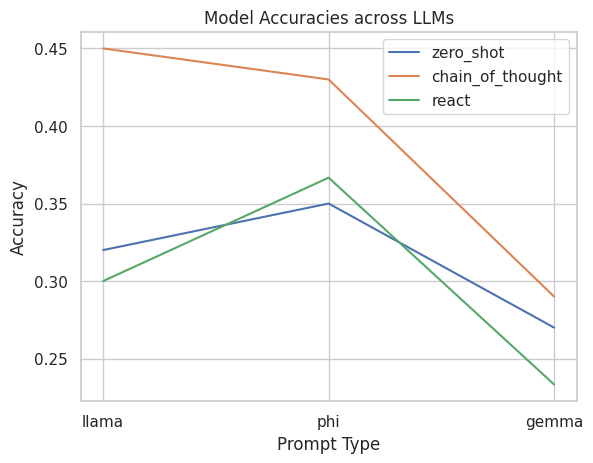

In [211]:
plt.plot(accuracies_df.T)
plt.legend(accuracies_df.T.columns)
plt.ylabel('Accuracy')
plt.xlabel('Prompt Type')
plt.title('Model Accuracies across LLMs')
plt.show()

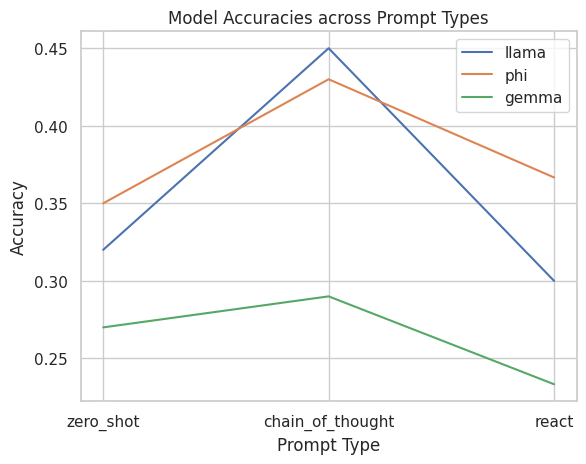

In [210]:
plt.plot(accuracies_df)
plt.legend(accuracies_df.columns)
plt.ylabel('Accuracy')
plt.xlabel('Prompt Type')
plt.title('Model Accuracies across Prompt Types')
plt.show()

##### LLM Inference Time

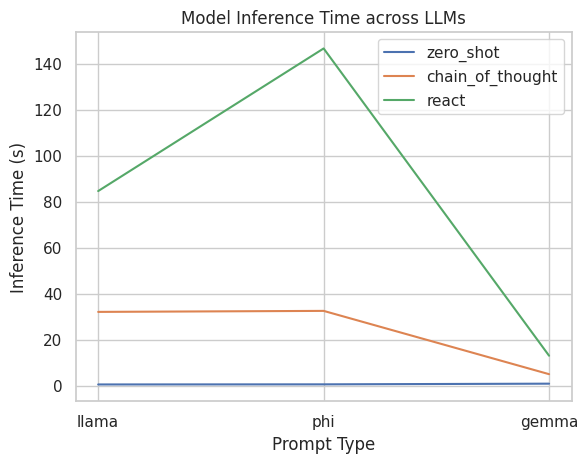

In [221]:
plt.plot(times_df.T)
plt.legend(times_df.T.columns)
plt.ylabel('Inference Time (s)')
plt.xlabel('Prompt Type')
plt.title('Model Inference Time across LLMs')
plt.show()

##### LLM Model Size

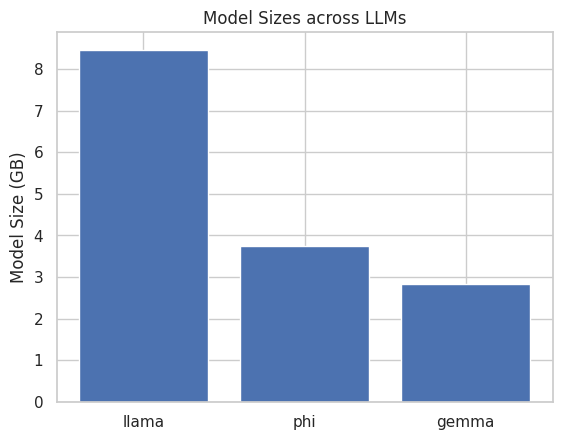

In [222]:
# Plot sizes_array
plt.bar(llm_types, sizes_array)
plt.ylabel('Model Size (GB)')
plt.title('Model Sizes across LLMs')
plt.show()